In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import more_itertools

from keras.models import Sequential
from keras.layers import LSTM, Dense

2021-08-24 18:27:40.621860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-24 18:27:40.621888: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preparação dos dados

Dividir uma sequência univariada em amostras

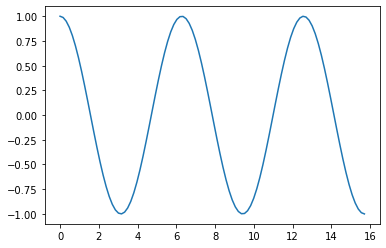

In [2]:
X = np.linspace(0, 5*np.pi, 100, endpoint=True)
C = np.cos(X)

# transform numpy array to list
C = C.tolist()

plt.plot(X, C)
plt.show()

In [3]:
print(C)

[1.0, 0.9874388886763943, 0.9500711177409454, 0.8888354486549235, 0.8052702575310586, 0.7014748877063213, 0.5800569095711982, 0.44406661260577424, 0.2969203753282749, 0.14231483827328512, -0.015865963834807807, -0.1736481776669303, -0.32706796331742166, -0.4722710747726826, -0.6056096871376665, -0.7237340381050702, -0.8236765814298327, -0.9029265382866211, -0.9594929736144974, -0.9919548128307953, -0.9994965423831852, -0.9819286972627067, -0.9396926207859084, -0.873849377069785, -0.7860530947427874, -0.6785094115571322, -0.5539200638661105, -0.4154150130018864, -0.2664738136900355, -0.11083819990101122, 0.04758191582374238, 0.20480666806519018, 0.35688622159187167, 0.5000000000000001, 0.6305526670845221, 0.7452644496757546, 0.8412535328311812, 0.9161084574320694, 0.9679487013963562, 0.9954719225730846, 0.9979866764718844, 0.975429786885407, 0.9283679330160726, 0.8579834132349773, 0.7660444431189781, 0.654860733945285, 0.5272254676105028, 0.3863451256931288, 0.2357589355094271, 0.079249

Podemos dividir a sequência em vários padrões de entrada / saída chamados amostras, onde três etapas de tempo são usadas como entrada e uma etapa de tempo é usada como saída para a previsão de uma etapa que está sendo aprendida.

In [6]:
# Função para dividir uma sequência univariada em amostras para o método de janelas
# X - amostras de entrada; y - variável que será predita

def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [7]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(C, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[1.         0.98743889 0.95007112] 0.8888354486549235
[0.98743889 0.95007112 0.88883545] 0.8052702575310586
[0.95007112 0.88883545 0.80527026] 0.7014748877063213
[0.88883545 0.80527026 0.70147489] 0.5800569095711982
[0.80527026 0.70147489 0.58005691] 0.44406661260577424
[0.70147489 0.58005691 0.44406661] 0.2969203753282749
[0.58005691 0.44406661 0.29692038] 0.14231483827328512
[0.44406661 0.29692038 0.14231484] -0.015865963834807807
[ 0.29692038  0.14231484 -0.01586596] -0.1736481776669303
[ 0.14231484 -0.01586596 -0.17364818] -0.32706796331742166
[-0.01586596 -0.17364818 -0.32706796] -0.4722710747726826
[-0.17364818 -0.32706796 -0.47227107] -0.6056096871376665
[-0.32706796 -0.47227107 -0.60560969] -0.7237340381050702
[-0.47227107 -0.60560969 -0.72373404] -0.8236765814298327
[-0.60560969 -0.72373404 -0.82367658] -0.9029265382866211
[-0.72373404 -0.82367658 -0.90292654] -0.9594929736144974
[-0.82367658 -0.90292654 -0.95949297] -0.9919548128307953
[-0.90292654 -0.95949297 -0.99195481] -0

In [8]:
n_features = 1 # série temporal univariada (uma variável de predição)

In [9]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

# Modelos LSTM para séries temporais univariadas

## Vanilla LSTM

Vanilla LSTM é um modelo que possui apenas uma camada escondida (hidden layer). E uma camada de saída para realizar a predição. 

### Definindo o modelo LSTM Vanilla

In [10]:
# Definindo o modelo
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2021-08-24 18:28:54.872855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-24 18:28:54.872890: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-24 18:28:54.872917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gabriel-gabriel): /proc/driver/nvidia/version does not exist
2021-08-24 18:28:54.873181: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# fit model
model.fit(X, y, epochs=200, verbose=2)

2021-08-24 18:28:55.130330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
4/4 - 1s - loss: 0.5158
Epoch 2/200
4/4 - 0s - loss: 0.4844
Epoch 3/200
4/4 - 0s - loss: 0.4566
Epoch 4/200
4/4 - 0s - loss: 0.4296
Epoch 5/200
4/4 - 0s - loss: 0.4049
Epoch 6/200
4/4 - 0s - loss: 0.3806
Epoch 7/200
4/4 - 0s - loss: 0.3576
Epoch 8/200
4/4 - 0s - loss: 0.3339
Epoch 9/200
4/4 - 0s - loss: 0.3104
Epoch 10/200
4/4 - 0s - loss: 0.2875
Epoch 11/200
4/4 - 0s - loss: 0.2651
Epoch 12/200
4/4 - 0s - loss: 0.2416
Epoch 13/200
4/4 - 0s - loss: 0.2199
Epoch 14/200
4/4 - 0s - loss: 0.1973
Epoch 15/200
4/4 - 0s - loss: 0.1750
Epoch 16/200
4/4 - 0s - loss: 0.1531
Epoch 17/200
4/4 - 0s - loss: 0.1318
Epoch 18/200
4/4 - 0s - loss: 0.1127
Epoch 19/200
4/4 - 0s - loss: 0.0962
Epoch 20/200
4/4 - 0s - loss: 0.0826
Epoch 21/200
4/4 - 0s - loss: 0.0709
Epoch 22/200
4/4 - 0s - loss: 0.0620
Epoch 23/200
4/4 - 0s - loss: 0.0558
Epoch 24/200
4/4 - 0s - loss: 0.0513
Epoch 25/200
4/4 - 0s - loss: 0.0486
Epoch 26/200
4/4 - 0s - loss: 0.0475
Epoch 27/200
4/4 - 0s - loss: 0.0470
Epoch 28/2